In [2]:
import pandas as pd
import numpy as np
import os
import requests
import re
import s3fs
from dotenv import load_dotenv

In [3]:
pd.set_option('display.max_columns', False)

In [4]:
#### Helper Functions
def pull_api(path):
    load_dotenv()
    # ACQUIRE JSON WEB TOKEN (JWT) WHICH HAS A LIMITED LIFE SPAN
    token_url = os.getenv('PFF_API_URL') + '/auth/login'
    jwt = requests.post(token_url, headers={'x-api-key': os.getenv('PFF_API_KEY')}).json()['jwt']

    # GET DATA FROM API
    x = requests.get(os.getenv('PFF_API_URL') + '/' + path, headers={'Authorization': 'Bearer ' + jwt, 'Accept-Encoding': 'gzip'})
    return pd.json_normalize(pd.DataFrame(x.json()).iloc[:, 0])

def pull_s3(obj_base, season_start=2006, season_end=2020, bucket="api", join_odds=False):
    load_dotenv()
    if not (bucket in ["api", "ml"]):
        raise Exception("Bucket must be either 'api' or 'ml'!")
    else:
        if bucket == "api":
            bucket_full = os.getenv('FEEDS_BUCKET') 
        else:
            bucket_full = os.getenv('ML_BUCKET')
    # FRESH DF
    df_list = []
    i = 1
    # IS THE API SEASON DEPENDENT
    seasonal = re.search("%", obj_base) != None
    # ONLY LOOP IF YOU HAVE A SEASON COMPONENT
    if seasonal:
        seasons = range(season_start, season_end + 1)
        for i in seasons:
            obj_name = obj_base % i
            temp = pd.read_csv(
                "s3://%s/%s" % (bucket_full, obj_name),
                dtype={"Season": "object", "Daynum": "object", "GameID": "object"},
                converters={"Season": lambda x: str(x), "Daynum": lambda x: str(x), "GameID": lambda x: str(x)},
                na_values=[""],
                low_memory=False,
            )
            df_list.append(temp)
            i += 1
        df = pd.concat(df_list)
    else:
        df = pd.read_csv(
            "s3://%s/%s" % (bucket_full, obj_base),
            dtype={"Season": "object", "Daynum": "object", "GameID": "object"},
            converters={"Season": lambda x: str(x), "Daynum": lambda x: str(x), "GameID": lambda x: str(x)},
            na_values=[""],
            low_memory=False,
        )
        if join_odds:
            odds = pd.read_csv(
                "s3://%s/flat_files/betting_odds_history_v2.csv" % os.getenv('ML_BUCKET'),
                dtype={"Season": "object", "Daynum": "object", "GameID": "object"},
                converters={"Season": lambda x: str(x), "Daynum": lambda x: str(x), "GameID": lambda x: str(x)},
                na_values=[""],
                low_memory=False,
            )
            df = join_odds(df, odds)
    return df

def write_s3(folder_name, file_name,data):
    load_dotenv()
    bucket = os.getenv('ML_BUCKET')
    storage_options = dict(anon=False, s3_additional_kwargs=dict(ServerSideEncryption="AES256"))
    s3 = s3fs.S3FileSystem(**storage_options)
    if isinstance(data,pd.DataFrame):
        data.to_csv(f's3://{bucket}/{folder_name}/{file_name}.csv', index=False, storage_options=storage_options)
    else:
        with s3.open(f's3://{bucket}/{folder_name}/{file_name}', 'wb') as f:
            f.write(data)


In [5]:
# step 1: explore data we have to use for offer decision model

# player grades/WAR data to explore
#GET /grades/:league/game_grade
#GET /grades/:league/games/:game_id/game_grade
#GET /grades/:league/:season/:week_id/season_grade
#GET /grades/:league/:season/game_grade
#GET /grades/:league/:season/season_grade
# pull_s3("iq/nfl/%i/war.csv.gz",2014,2021)

# cap and contract data to explore
# cap21 = pd.read_csv('../data/2021Cap.csv')
# contracts21 = pd.read_excel('../data/2021ContractData.xlsx')

# Desired columns for offer decision model
# player_id, name, franchise_id, team, position, role, years_in_league, pff_grade_career, pff_grade_year_prior, pff_war_career, pff_war_year_prior,
# contract_type, year_signed, start_year, years, total, apy, guarantee, bonus(combine all bonus columns), cap_hit, dead_money

In [6]:
#### Contract and Cap Data ####

In [7]:
cap20 = pd.read_csv('../data/2020Cap.csv')
contracts20 = pd.read_csv('../data/2020Contracts.csv')
cap21 = pd.read_csv('../data/2021Cap.csv')
contracts21 = pd.read_excel('../data/2021ContractData.xlsx')
cap22 = pd.read_csv('../data/2022Cap.csv')
contracts22 = pd.read_csv('../data/2022Contracts.csv')

In [8]:
cap21.head()

,player_id,franchise_id,contract_id,year,base_salary,contract_type,prorated_bonus,roster_bonus,per_game_roster_bonus,workout_bonus,other_bonus,cap_hit,dead_money,cap_savings,guaranteed_base_salary,cash_bonus,cash_pay,cash_to_cap_ratio,initial_cash,old_money,cash_dead,provisional,credits
0,217,9,3388,2013,940000,UFA,0.0,0.0,0.0,0.0,0.0,32647,0.0,32647.0,0.0,0.0,56471.0,1.73,0,0,0.0,NaN,0.0
1,226,14,1303,2016,3250000,UFA,0.0,0.0,0.0,0.0,500000.0,3750000,NaN,NaN,1000000.0,0.0,3250000.0,NaN,3250000,0,0.0,NaN,0.0
2,226,14,1303,2017,2750000,UFA,0.0,0.0,0.0,0.0,0.0,2750000,NaN,NaN,0.0,0.0,2750000.0,NaN,2750000,0,0.0,NaN,0.0
3,226,14,6997,2013,2000000,UFA,1200000.0,200000.0,0.0,0.0,0.0,3400000,NaN,NaN,0.0,0.0,2200000.0,NaN,2200000,0,0.0,NaN,0.0
4,226,14,12025,2014,2000000,UFA,250000.0,0.0,0.0,0.0,0.0,2250000,NaN,NaN,0.0,500000.0,2500000.0,NaN,2500000,0,0.0,NaN,0.0


In [9]:
#need pff_id, Name, 
#contracts21[contracts21['Name'] == 'Trent Williams'].head()
contracts21[contracts21['Name'] == 'Patrick Mahomes'].head()

,Name,Team,pff_id,pff_franchise_id,ID,player_id,team_id,Position,Role,Years,date_signed,year_signed,start_year,Total,APY,Guarantee,GPY,GP,total_guarantees,vested_guarantees,signing_bonus,option_bonus,roster_bonus,pergame_bonus,workout_bonus,incentives,FA,Status,is_featured,is_front,contract_type,ID2
754,Patrick Mahomes,Chiefs,11765,16,27268,5594,14,QB,Offense,10,2020-07-06 00:00:00,2020,2022,450000000,45000000,63081905,0,0.0,141000000,78000000,10000000,0,337216905,0,5600000,25000000,NaN,Active,NaN,NaN,Extension,NaN


In [136]:
contracts21['contract_type'].value_counts()
# drafted is rookie contract?

Drafted      748
Practice     523
SFA          433
UFA          363
Extension    176
UDFA          93
ERFA          50
Other         49
RFA           48
Franchise     18
Name: contract_type, dtype: int64

In [8]:
#### Player Grade/Stats Data ####

In [9]:
pull_s3("master_data/players/export.csv.gz")
#pull_api("/v1/player_combine_results")
#pull_api("/v1/player_pro_day")

,id,first_name,last_name,college_gsis_id,gsis_id,gsis_alt_id,dob,height,weight,speed,current_eligible_year,current_class,draft_type_id,draft_franchise_id,draft_season_id,draft_round,draft_selection,retired_season_id,hometown_id,college_id,current_team,current_jersey_number,current_position,current_status,season_position,current_franchise_id,current_team_abbreviation,current_league_id,current_league
0,91846,Kevin,Burke,0.0,NaN,NaN,1993-02-24,511.0,190.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,873.0,1006.0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28590,Dalton,Harman,305099.0,NaN,NaN,NaN,602.0,245.0,NaN,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2838.0,199.0,NaN,S38,NaN,NaN,LS,NaN,NaN,NaN,NaN
2,84028,Tate,Duarte,306361.0,NaN,NaN,NaN,605.0,248.0,NaN,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2784.0,260.0,NaN,48,NaN,NaN,TE,NaN,NaN,NaN,NaN
3,138363,Ahmed,Bailey,354640.0,NaN,NaN,NaN,600.0,190.0,NaN,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,214.0,NaN,Delaware State,D52,SLB,A,LB,152.0,DSU,2.0,NCAA
4,78217,Unknown,Long Beach Poly 60,NaN,NaN,NaN,NaN,0.0,0.0,NaN,2019.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.0,NaN,Poly/Long Beach,60,RG,A,G,549.0,CALB,3.0,HS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138806,113070,Tommy,Taylor,339814.0,NaN,NaN,NaN,603.0,298.0,NaN,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1538.0,NaN,UVA Wise,78,RG,A,G,1320.0,VAW,2.0,NCAA
138807,113097,Joey,Vandyke,332154.0,NaN,NaN,NaN,602.0,220.0,NaN,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989.0,NaN,UVA Wise,89,TE-R,A,TE,1320.0,VAW,2.0,NCAA
138808,113108,Myles,Ward,332158.0,NaN,NaN,NaN,602.0,235.0,NaN,2024.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2740.0,NaN,UVA Wise,14,LWR,A,WR,1320.0,VAW,2.0,NCAA
138809,113051,Caleb,Wilkins,332161.0,NaN,NaN,NaN,509.0,215.0,NaN,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,348.0,NaN,UVA Wise,D26,MLB,A,LB,1320.0,VAW,2.0,NCAA


In [10]:
#### WAR Stuff ####

In [11]:
#pff_WAR = pull_s3("iq/nfl/%i/war.csv.gz",2014,2021)
pff_war = pull_s3("iq/nfl/2021/war.csv.gz")
war_cols = [
    'player_id',
    'player',
    'season',
    'year_in_league',
    'season_count',
    'war',
    'waa'
]
pff_war = pff_war[war_cols]
#aggregate to account for playes who played on multiple teams in 2021
#pff_war = pff_war.groupby(['player_id', 'player', 'season'], as_index=False).mean()
pff_war = pff_war.groupby(['player_id', 'player'], as_index=False).mean()

In [12]:
# check which players are duplicated and why
# some players duplicated because of playing on different teams in season
#pff_war[pff_war['player_id'].isin(pff_war['player_id'][pff_war['player_id'].duplicated()])].sort_values('player_id')

In [13]:
#need player_id, season, year_in_league, season_count, war, waa
pff_war.head()

,player_id,player,season,year_in_league,season_count,war,waa
0,698,Tom Brady,2021.0,20.0,19.0,5.118,2.527581
1,1732,Ben Roethlisberger,2021.0,17.0,16.0,-0.180,-2.356419
2,1906,Andy Lee,2021.0,17.0,16.0,-0.037,-0.040851
3,2148,Jason Peters,2021.0,16.0,15.0,0.107,0.031184
4,2241,Aaron Rodgers,2021.0,17.0,16.0,3.278,1.381581


In [14]:
#### Grades stuff ####

In [15]:
#GET /grades/:league/game_grade
#GET /grades/:league/games/:game_id/game_grade
#GET /grades/:league/:season/:week_id/season_grade
#GET /grades/:league/:season/game_grade
#GET /grades/:league/:season/season_grade
pff_grades = pull_api('/v1/grades/nfl/2021/season_grade')
#player_id = pff_id
grade_cols = [
    'player_id',
    'position',
    'unit',
    'season',
    #'discipline',
    'offense',
    'pass_block',
    'run_block',
    'receiving',
    'pass',
    'run',
    'defense',
    'coverage',
    'pass_rush',
    'run_defense'
]
pff_grades = pff_grades[grade_cols]
#aggregate to season grade
pff_grades = pff_grades.groupby(['player_id', 'position', 'unit', 'season'], as_index=False).mean()

In [16]:
pff_grades[pff_grades['player_id'] == 5529]

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense
43,5529,T,offense,2021,95.290909,82.05,95.909091,57.7,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
special_grades = pull_api('/v1/grades/nfl/2021/season_grade')
special_grades[special_grades['unit'] == 'special_teams'].head()

,discipline,offense,player,player_id,position,receiving,receiving_snaps,run_block,run_block_snaps,season,total_snaps,unit,week,coverage,coverage_rank,coverage_snaps,defense,defense_rank,pass_rush,pass_rush_snaps,run_defense,run_defense_rank,run_defense_snaps,offense_rank,pass_block,pass_block_snaps,receiving_rank,run,run_block_rank,run_snaps,pass_block_rank,pass_rush_rank,pass,pass_snaps,run_rank,pass_rank
15,32.5,60.0,J.J. Jansen,4712,LS,NaN,NaN,60.0,1.0,2021,210,special_teams,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,63.1,NaN,Joey Slye,39235,K,NaN,NaN,NaN,NaN,2021,105,special_teams,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,62.0,NaN,Elliott Fry,21473,K,NaN,NaN,NaN,NaN,2021,22,special_teams,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,67.8,60.0,Matt Orzech,94369,LS,NaN,NaN,60.0,1.0,2021,223,special_teams,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,88.0,2.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
87,63.4,NaN,Jason Sanders,29578,K,NaN,NaN,NaN,NaN,2021,144,special_teams,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
#need player_id, position, unit, season
# offense(grade), pass_block(grade), run_block(grade), receiving(grade), pass(grade), run(grade)
# defense(grade), coverage(grade), pass_rush(grade), run_defense(grade), 
pff_grades.head()

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense
0,698,QB,offense,2021,91.868182,NaN,60.000000,58.9,90.445455,76.114286,NaN,NaN,NaN,NaN
1,1732,QB,offense,2021,55.495455,NaN,60.000000,NaN,54.781818,61.127273,NaN,NaN,NaN,NaN
2,1906,P,special_teams,2021,47.760000,NaN,NaN,56.8,60.000000,60.000000,NaN,NaN,NaN,NaN
3,2148,T,offense,2021,76.059091,74.818182,71.477273,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2241,QB,offense,2021,78.986364,NaN,60.000000,NaN,77.390909,65.700000,NaN,NaN,NaN,NaN


In [19]:
#### Player Measurements ####

In [20]:
player_measurements = pull_s3("master_data/players/export.csv.gz")
measurement_cols = [
    'id',
    'height',
    'weight'
]
player_measurements = player_measurements[measurement_cols].rename(columns={'id': 'player_id'})

In [21]:
#need player id, height, weight
player_measurements.head()

,player_id,height,weight
0,91846,511.0,190.0
1,28590,602.0,245.0
2,84028,605.0,248.0
3,138363,600.0,190.0
4,78217,0.0,0.0


In [22]:
#### Snap counts ####

In [100]:
snaps = pull_api('/v1/fantasy/nfl/2021/snaps')

In [101]:
#only want regular season and playoff snaps
#snaps = snaps[snaps['week'] > 0]
#snaps['total_snap_count'] = snaps.groupby(['player_id', 'position'])['snap_count'].transform('sum')
#snaps['total_positions_played'] = snaps.groupby(['player_id'])['position'].transform('nunique')

In [102]:
snaps = snaps[snaps['week'] > 0] #only want regular season and playoff snaps
snaps['total_alignments_played'] = snaps.groupby(['player_id'])['position'].transform('nunique') #count of all different alignments played during season
positions_conditions = [(snaps["position"] == "HB") | (snaps["position"] == "HB-L") | (snaps["position"] == "HB-R"),
                        (snaps["position"] == "LWR") | (snaps["position"] == "RWR"), 
                        (snaps["position"] == "SLiWR") |
                        (snaps["position"] == "SRiWR") | (snaps["position"] == "SLoWR") | (snaps["position"] == "SRoWR") |
                        (snaps["position"] == "SLWR") | (snaps["position"] == "SRWR"),
                        (snaps["position"] == "QB"), 
                        (snaps["position"] == "LT"),
                        (snaps["position"] == "LG"),
                        (snaps["position"] == "C"),
                        (snaps["position"] == "RG"),
                        (snaps["position"] == "RT"),
                        (snaps["position"] == "FB") | (snaps["position"] == "FB-iL") | (snaps["position"] == "FB-iR") |
                        (snaps["position"] == "FB-oL") | (snaps["position"] == "FB-oR") | (snaps["position"] == "FB-L") | (snaps["position"] == "FB-R"),
                        (snaps["position"] == "TE-L") | (snaps["position"] == "TE-R") | (snaps["position"] == "TE-iL") |
                        (snaps["position"] == "TE-iR") | (snaps["position"] == "TE-oL") | (snaps["position"] == "TE-oR"),
                        ((snaps['position'] == 'LEO') | (snaps['position'] == 'LOLB')),
                        ((snaps['position'] == 'REO') | (snaps['position'] == 'ROLB')),
                        ((snaps['position'] == 'LE') | (snaps['position'] == 'DLT')),
                        ((snaps['position'] == 'RE') | (snaps['position'] == 'DRT')),
                        ((snaps['position'] == 'NLT') | (snaps['position'] == 'NRT') | (snaps['position'] == 'NT')),
                        ((snaps['position'] == 'MLB') | (snaps['position'] == 'RLB') | (snaps['position'] == 'LLB') | (snaps['position'] == 'RILB') | (snaps['position'] == 'LILB')),
                        ((snaps['position'] == 'SCBiL') | (snaps['position'] == 'SCBoL') | (snaps['position'] == 'SCBiR') | (snaps['position'] == 'SCBoR') | (snaps['position'] == 'SCBL') | (snaps['position'] == 'SCBR')),
                        ((snaps['position'] == 'LCB') | (snaps['position'] == 'RCB')),
                        ((snaps['position'] == 'FS') | (snaps['position'] == 'FSR') | (snaps['position'] == 'FSL')),
                        ((snaps['position'] == 'SS') | (snaps['position'] == 'SSR') | (snaps['position'] == 'SSL'))]
positions_choices = ["HB", "WR", "SWR", "QB", "LT", "LG", "C", "RG", "RT", "FB", "TE", 
                    'LED', 'RED', 'LID', 'RID', 'NT', 'LB', 'SCB', 'CB', 'FS', 'SS']
snaps["position"] = np.select(positions_conditions, positions_choices, default=snaps['position'])
snaps['total_positions_played'] = snaps.groupby(['player_id'])['position'].transform('nunique') #total number of positions played throughout season
snaps['total_snap_count'] = snaps.groupby(['player_id'])['snap_count'].transform('sum')
snaps['weeks_played'] = snaps.groupby(['player_id'])['week'].transform('nunique')
snaps['snap_count_per_week_played'] = snaps['total_snap_count']/snaps['weeks_played']
snaps['snaps_by_position'] = snaps.groupby(['player_id', 'position'])['snap_count'].transform('sum')
for position in positions_choices:
    snaps[position+'_total_snaps'] = np.where(snaps['position'] == position, snaps['snaps_by_position'], 0)
snaps = snaps.drop_duplicates(subset=['player_id', 'position'])
for position in positions_choices:
    snaps[position+'_total_snaps'] = snaps.groupby(['player_id'])[position+'_total_snaps'].transform('sum')

snaps_cols = [
    'player_id',
    'season', 
    'total_alignments_played', 
    'total_positions_played', 
    'total_snap_count', 
    'weeks_played', 
    'snap_count_per_week_played',
    'HB_total_snaps',
    'WR_total_snaps',
    'SWR_total_snaps',
    'QB_total_snaps',
    'LT_total_snaps',
    'LG_total_snaps',
    'C_total_snaps',
    'RG_total_snaps',
    'RT_total_snaps',
    'FB_total_snaps',
    'TE_total_snaps',
    'LED_total_snaps',
    'RED_total_snaps',
    'LID_total_snaps',
    'RID_total_snaps',
    'NT_total_snaps',
    'LB_total_snaps',
    'SCB_total_snaps',
    'CB_total_snaps',
    'FS_total_snaps',
    'SS_total_snaps'
]
position_snaps_cols = [
    'HB_total_snaps',
    'WR_total_snaps',
    'SWR_total_snaps',
    'QB_total_snaps',
    'LT_total_snaps',
    'LG_total_snaps',
    'C_total_snaps',
    'RG_total_snaps',
    'RT_total_snaps',
    'FB_total_snaps',
    'TE_total_snaps',
    'LED_total_snaps',
    'RED_total_snaps',
    'LID_total_snaps',
    'RID_total_snaps',
    'NT_total_snaps',
    'LB_total_snaps',
    'SCB_total_snaps',
    'CB_total_snaps',
    'FS_total_snaps',
    'SS_total_snaps'
]

snaps = snaps[snaps_cols]
snaps = snaps.drop_duplicates()
snaps['main_position'] = snaps[position_snaps_cols].idxmax(axis=1)
snaps['main_position'] = snaps['main_position'].apply(lambda x: str(x).removesuffix('_total_snaps'))

In [103]:
snaps.head()

,player_id,season,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position
0,698,2021,1,1,1303,19,68.578947,0,0,0,1303,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,QB
1,4317,2021,3,2,1049,17,61.705882,0,5,0,1044,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,QB
3,5232,2021,9,5,300,14,21.428571,0,0,0,0,0,0,0,0,0,0,0,0,1,149,128,21,1,0,0,0,0,LID
8,5527,2021,13,6,815,19,42.894737,0,0,0,0,0,0,0,0,0,0,0,40,9,593,159,10,4,0,0,0,0,LID
12,5540,2021,15,6,718,14,51.285714,0,0,0,0,0,0,0,0,0,0,0,321,357,5,14,0,15,6,0,0,0,RED


In [104]:
#snaps['position'].value_counts()
#snaps[(snaps['last_name'] == 'Kupp') & (snaps['week'] == 18)]
snaps[snaps['player_id'] == 11824]

,player_id,season,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position
3933,11824,2021,14,5,1324,21,63.047619,15,456,843,0,0,0,0,0,0,6,4,0,0,0,0,0,0,0,0,0,0,SWR


In [105]:
#### Receiving Stuff ####

In [106]:
receiving = pull_api('/v1/analytics/projections/by_facet/nfl/2021/receiving')

In [107]:
receiving[receiving['play_id'] == 4412472]

,home_team,quarter,extra_point,player,attempt,off_score_before,screen,blitz,away_franchise_id,def_score_before,num_pass_rush_players,defense_franchise_id,down,seconds_left_in_quarter,pass_direction,defense_personnel,play_sequence,pass_depth,box_player_count,offense_franchise_id,time_to_throw,dropback_type,no_play,dropback,yards_after_catch,distance,rps,dropback_depth,play_action,rpo,position,home_franchise_id,pistol,offense,is_preseason,away_team,play_id,game_id,defense,week,coverage_scheme,yards,yards_to_go,season,shotgun,completion,player_id,press,route,target,receiver_grade,pressure,hurry,time_to_pressure,touchdown,passer_grade,hit,playled,contested_target,thrown_away,missed_tackles,broken_up_pass,drop,run,hurry_qb,sack_qb,sack,bat,fumbles,hit_as_threw,hit_qb,interception,spike
0,BUF,1,0,Stefon Diggs,1.0,0,1,0,22,0,4.0,22,1,900,C,4-2-5,2,-4.0,7,4,2.3,SD,0,1,21.0,10,P,8,1,0,RWR,4,0,BUF,0,NYJ,4412472,19866,NYJ,18,3,17.0,75,2021,0,1.0,9579,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BUF,1,0,Gabriel Davis,1.0,0,1,0,22,0,4.0,22,1,900,C,4-2-5,2,-4.0,7,4,2.3,SD,0,1,21.0,10,P,8,1,0,LWR,4,0,BUF,0,NYJ,4412472,19866,NYJ,18,3,17.0,75,2021,0,1.0,55410,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BUF,1,0,Devin Singletary,1.0,0,1,0,22,0,4.0,22,1,900,C,4-2-5,2,-4.0,7,4,2.3,SD,0,1,21.0,10,P,8,1,0,HB,4,0,BUF,0,NYJ,4412472,19866,NYJ,18,3,17.0,75,2021,0,1.0,40485,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BUF,1,0,Dawson Knox,1.0,0,1,0,22,0,4.0,22,1,900,C,4-2-5,2,-4.0,7,4,2.3,SD,0,1,21.0,10,P,8,1,0,TE-R,4,0,BUF,0,NYJ,4412472,19866,NYJ,18,3,17.0,75,2021,0,1.0,35883,NaN,0R,1.0,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BUF,1,0,Isaiah McKenzie,1.0,0,1,0,22,0,4.0,22,1,900,C,4-2-5,2,-4.0,7,4,2.3,SD,0,1,21.0,10,P,8,1,0,SRWR,4,0,BUF,0,NYJ,4412472,19866,NYJ,18,3,17.0,75,2021,0,1.0,11927,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [108]:
#pull_s3("football_sim_rd/offense_fantasy_shares.csv", bucket = "ml")

In [109]:
# Step 2: offer suggestion model

# Goal to have model that would suggest N offers.
# Offers range from definite decline, could go any direction(almost equal chance to decline, counter, or accept), or definite accept

# inputs: length, player info, team info, salary cap info
# outputs: N contract offers for user to choose from

# ideas
# potentially use the contracts of the 5-10 most similar players graded above and below to build suggested contracts
# maybe make clusters based on war and grades and size to make clusters within position group and figure out contract suggestions
# based on position cluster

In [110]:
# merge players, war, and grades
players = pd.merge(pff_grades, pff_war, on=['player_id', 'season'], how='left')
players = pd.merge(players, player_measurements, on='player_id', how='left')
players = pd.merge(players, snaps, on=['player_id', 'season'], how='left')


In [111]:
players.isna().sum()

player_id                        0
position                         0
unit                             0
season                           0
offense                       1099
pass_block                    1531
run_block                     1208
receiving                     1644
pass                          2177
run                           1934
defense                       1180
coverage                      1318
pass_rush                     1412
run_defense                   1237
player                         172
year_in_league                 172
season_count                   172
war                            172
waa                            172
height                           4
weight                           4
total_alignments_played        239
total_positions_played         239
total_snap_count               239
weeks_played                   239
snap_count_per_week_played     239
HB_total_snaps                 239
WR_total_snaps                 239
SWR_total_snaps     

In [112]:
players['position'].value_counts()

WR    272
CB    259
LB    228
DI    226
ED    213
S     195
HB    159
T     156
TE    149
G     145
QB     85
C      67
K      47
P      40
LS     35
FB     27
Name: position, dtype: int64

In [113]:
WRs = players[players['position'] == 'WR']

In [114]:
WRs.head()

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position
20,4363,WR,offense,2021,70.568182,NaN,58.031818,70.495455,NaN,56.600000,60.0,NaN,NaN,60.0,DeSean Jackson,14.0,13.0,0.0380,0.000462,510.0,175.0,9.0,3.0,328.0,17.0,19.294118,0.0,257.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR
23,4467,WR,offense,2021,60.136842,NaN,60.000000,NaN,NaN,NaN,70.2,60.7,NaN,NaN,Matthew Slater,14.0,13.0,0.0120,0.011462,600.0,205.0,1.0,1.0,16.0,9.0,1.777778,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HB
27,4717,WR,offense,2021,58.736364,NaN,56.677273,61.145455,32.4,NaN,NaN,NaN,NaN,NaN,Danny Amendola,13.0,12.0,-0.0410,-0.095538,511.0,190.0,10.0,4.0,194.0,8.0,24.250000,1.0,50.0,142.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR
56,5606,WR,offense,2021,67.709091,NaN,47.500000,69.922727,NaN,65.863158,NaN,NaN,NaN,NaN,Emmanuel Sanders,12.0,11.0,0.1690,-0.017538,511.0,180.0,8.0,2.0,806.0,16.0,50.375000,0.0,667.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR
59,5612,WR,offense,2021,60.190476,NaN,60.642857,59.676190,NaN,60.042857,70.2,60.7,NaN,NaN,Andre Roberts,12.0,11.0,0.0015,-0.003038,511.0,195.0,6.0,2.0,34.0,7.0,4.857143,0.0,18.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR


In [115]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt


In [116]:
#TODO incorporate routes, targets, and all positions played, maybe snaps at each position
# this will be the second step of clustering
#cluster step 1: cluster on grades and usage
# cluster step 2: cluster on routes, targets, positions and more granular stats to separate out the clusters
# from there can grab a distribution of contracts to use as basis of suggested offers

# look into model based clustering where some players may fit into model based clusters

# look at how players clsuters evolve over time i.e. player x went from one trick pony year 1 to a multi trick which is why they got paid

In [117]:
#cluster step 1: cluster on grades and usage
#look to add in snap counts, snap count percentage, routes run/route depth, etc to distinguish types of WRs
offense_cluster_cols = [
    'offense',
    #'pass_block',
    #'run_block',
    #'receiving',
    #'run',
    'war',
    #'waa',
    #'height',
    #'weight',
    'year_in_league',
    'total_alignments_played',
    'total_positions_played',
    'total_snap_count',
    'weeks_played',
    'snap_count_per_week_played',
    'WR_total_snaps',
    'SWR_total_snaps'
]

In [118]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = WRs[offense_cluster_cols].fillna(0)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k)#.fit(X)
	kmeanModel.fit(X)

	distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / X.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / X.shape[0]
	mapping2[k] = kmeanModel.inertia_


c:\Users\Richard Clark\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [119]:
for key, val in mapping1.items():
	print(f'{key} : {val}')


1 : 399.687038362812
2 : 207.5783723276527
3 : 166.4509030028355
4 : 138.8289131309673
5 : 112.98646242480285
6 : 105.37708921236283
7 : 98.06817408307663
8 : 93.19063133179134
9 : 84.37308064311392


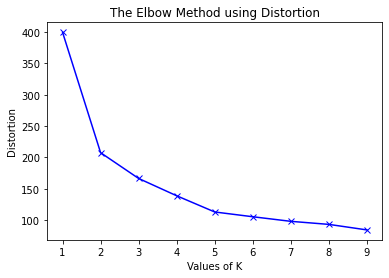

In [120]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


In [127]:
X = WRs[offense_cluster_cols].fillna(0)
kmeanModel = KMeans(n_clusters=5)#.fit(X)
kmeanModel.fit(X)

KMeans(n_clusters=5)

In [128]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeanModel.labels_)

0.5438156556077566

In [129]:
WRs['cluster'] = kmeanModel.labels_

C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_10864/4009089567.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WRs['cluster'] = kmeanModel.labels_


In [130]:
WRs['cluster'].value_counts()

0    117
2     57
1     42
4     36
3     20
Name: cluster, dtype: int64

In [131]:
WRs[WRs['cluster'] == 0].describe()

,player_id,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,cluster
count,117.000000,117.0,110.000000,13.000000,105.000000,96.000000,2.000000,18.000000,21.000000,1.100000e+01,1.0,9.0,111.000000,111.000000,111.000000,111.000000,117.000000,117.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.000000,110.0,110.0,110.0,110.0,110.0,110.000000,110.000000,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,110.0,117.0
mean,44022.017094,2021.0,58.617534,67.390989,60.055534,58.561029,69.900000,60.322211,65.801515,6.070000e+01,60.0,60.0,3.477477,2.477477,0.001515,-0.008858,568.888889,196.350427,6.481818,2.536364,55.600000,5.363636,11.143617,2.018182,33.363636,19.245455,0.018182,0.0,0.0,0.0,0.0,0.0,0.081818,0.872727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,27433.335083,0.0,6.878704,4.451448,8.349137,6.442930,1.555635,3.087957,5.075866,3.177644e-15,NaN,0.0,2.419041,2.419041,0.017696,0.017111,44.476995,16.389292,3.463391,0.925453,48.622153,4.548873,9.318375,3.780641,32.243832,22.844182,0.190693,0.0,0.0,0.0,0.0,0.0,0.361744,2.027830,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,4467.000000,2021.0,39.100000,62.300000,35.652941,41.400000,68.800000,56.000000,59.900000,6.070000e+01,60.0,60.0,1.000000,0.000000,-0.038000,-0.065538,507.000000,153.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,12739.000000,2021.0,54.836230,65.700000,57.427273,54.203434,69.350000,57.525000,60.000000,6.070000e+01,60.0,60.0,2.000000,1.000000,-0.006250,-0.017038,511.000000,184.000000,4.000000,2.000000,11.750000,2.000000,4.132212,0.000000,5.000000,2.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,47448.000000,2021.0,59.133333,66.200000,60.000000,58.231818,69.900000,59.971429,70.200000,6.070000e+01,60.0,60.0,3.000000,2.000000,-0.001000,-0.005538,601.000000,195.000000,6.000000,3.000000,43.500000,3.500000,8.788889,0.000000,23.000000,10.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,61324.000000,2021.0,61.750000,66.600000,60.772727,61.621591,70.450000,63.000000,70.200000,6.070000e+01,60.0,60.0,5.000000,4.000000,0.006000,-0.001038,603.000000,210.000000,9.000000,3.000000,87.500000,7.750000,14.625000,2.000000,51.000000,30.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,143358.000000,2021.0,83.854545,77.642857,85.805000,85.676190,71.000000,67.100000,70.900000,6.070000e+01,60.0,60.0,14.000000,13.000000,0.074000,0.048462,605.000000,228.000000,15.000000,4.000000,172.000000,18.000000,49.333333,17.000000,122.000000,120.000000,2.000000,0.0,0.0,0.0,0.0,0.0,3.000000,10.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
WRs[WRs['cluster'] == 0].sort_values(by='offense', ascending=False).head(10)

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster
1287,40568,WR,offense,2021,83.854545,75.0,67.872727,85.676190,NaN,62.662500,NaN,NaN,NaN,NaN,Demetric Felton,1.0,0.0,0.065,0.033462,510.0,200.0,13.0,4.0,132.0,15.0,8.800000,17.0,23.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0
716,11231,WR,offense,2021,81.300000,NaN,60.000000,76.700000,NaN,NaN,NaN,NaN,NaN,NaN,Tommylee Lewis,6.0,5.0,0.007,0.006462,507.0,168.0,3.0,2.0,3.0,1.0,3.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0
1298,40988,WR,offense,2021,75.646154,NaN,78.100000,71.330769,NaN,NaN,NaN,NaN,NaN,NaN,Frank Darby,1.0,0.0,-0.006,-0.010538,601.0,200.0,5.0,2.0,21.0,4.0,5.250000,0.0,18.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,0
1667,48078,WR,offense,2021,70.957895,70.2,58.247368,70.916667,NaN,NaN,70.3,60.7,NaN,NaN,Malik Turner,4.0,3.0,0.074,0.048462,602.0,202.0,12.0,4.0,132.0,13.0,10.153846,14.0,52.0,63.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0
104,6468,WR,offense,2021,69.895455,NaN,60.577273,69.450000,NaN,NaN,NaN,NaN,NaN,NaN,Chris Hogan,10.0,9.0,0.013,0.001462,601.0,210.0,9.0,3.0,71.0,5.0,14.200000,2.0,39.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,0
777,11795,WR,offense,2021,68.826316,NaN,64.115789,68.242105,NaN,60.794444,NaN,NaN,NaN,NaN,Curtis Samuel,5.0,4.0,0.015,-0.000538,511.0,195.0,12.0,4.0,89.0,5.0,17.800000,6.0,51.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,0
1680,48192,WR,offense,2021,68.650000,62.3,55.590909,70.536364,NaN,NaN,NaN,NaN,NaN,NaN,Auden Tate,4.0,3.0,0.030,0.013462,605.0,228.0,12.0,4.0,118.0,7.0,16.857143,1.0,84.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,0
1672,48113,WR,offense,2021,67.888235,NaN,60.658824,65.511765,68.8,NaN,NaN,NaN,NaN,NaN,Dante Pettis,4.0,3.0,0.050,0.025462,601.0,195.0,8.0,2.0,84.0,3.0,28.000000,0.0,39.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0
1054,28025,WR,offense,2021,67.859091,NaN,60.000000,66.327273,NaN,NaN,NaN,NaN,NaN,NaN,K.J. Hill,2.0,1.0,0.003,-0.000538,600.0,198.0,7.0,3.0,14.0,4.0,3.500000,3.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0
737,11440,WR,offense,2021,65.900000,NaN,59.566667,65.266667,NaN,NaN,NaN,NaN,NaN,NaN,Marvin Hall,6.0,5.0,0.006,0.003462,510.0,190.0,4.0,2.0,17.0,2.0,8.500000,0.0,13.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,0


In [132]:
WRs[WRs['cluster'] == 1].describe()

,player_id,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,cluster
count,42.0000,42.0,42.000000,20.000000,42.000000,42.000000,5.000000,16.000000,5.000000,1.000000,1.0,4.0,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.0,42.0,42.0,42.0,42.000000,42.000000,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.0,42.000000,42.0,42.0
mean,30441.5000,2021.0,64.241615,67.705664,57.450162,64.260221,60.238667,59.479377,60.742727,62.804545,60.0,60.0,4.690476,3.690476,0.093690,-0.031586,582.238095,203.095238,11.714286,3.642857,582.523810,14.071429,42.494397,2.547619,394.880952,177.738095,0.047619,0.047619,0.0,0.0,0.0,0.0,0.476190,6.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.119048,0.0,1.0
std,22706.7586,0.0,6.886409,6.866818,9.930082,6.578585,10.339564,7.688465,1.717236,NaN,NaN,0.0,2.513263,2.513263,0.089177,0.087317,38.558672,12.189179,2.898997,0.905846,89.616592,2.823187,7.841868,3.194526,99.510559,95.327436,0.308607,0.215540,0.0,0.0,0.0,0.0,1.329553,9.819509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.771517,0.0,0.0
min,6158.0000,2021.0,50.027273,45.295238,40.054545,50.640909,49.826667,40.590476,59.900000,62.804545,60.0,60.0,1.000000,0.000000,-0.050000,-0.182538,508.000000,177.000000,8.000000,2.000000,447.000000,9.000000,27.294118,0.000000,122.000000,28.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
25%,10137.2500,2021.0,59.050625,65.400000,49.917045,58.893608,50.100000,56.596591,60.000000,62.804545,60.0,60.0,3.000000,2.000000,0.038000,-0.086038,600.000000,195.250000,9.000000,3.000000,512.750000,12.000000,37.381373,0.000000,330.250000,95.250000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
50%,25826.5000,2021.0,64.000974,68.847619,55.165909,64.193182,60.000000,61.509091,60.000000,62.804545,60.0,60.0,4.500000,3.500000,0.088500,-0.039538,601.500000,204.000000,11.500000,4.000000,558.000000,14.000000,41.024510,1.000000,413.000000,185.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,4.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
75%,48005.7500,2021.0,69.618182,72.089286,64.062955,67.985227,70.266667,62.930065,60.000000,62.804545,60.0,60.0,6.750000,5.750000,0.152500,0.028462,603.000000,211.750000,13.000000,4.000000,633.000000,16.000000,48.362013,4.000000,462.750000,237.750000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0
max,84302.0000,2021.0,78.400000,77.771429,80.731818,79.572727,71.000000,71.133333,63.813636,62.804545,60.0,60.0,11.000000,10.000000,0.305000,0.149462,605.000000,227.000000,19.000000,6.000000,778.000000,19.000000,61.444444,10.000000,594.000000,413.000000,2.000000,1.000000,0.0,0.0,0.0,0.0,7.000000,58.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.000000,0.0,1.0


In [140]:
WRs[WRs['cluster'] == 1].sort_values(by='offense', ascending=False).head(10)

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster
184,7808,WR,offense,2021,78.400000,NaN,53.636364,79.572727,NaN,NaN,NaN,NaN,NaN,NaN,DeAndre Hopkins,9.0,8.0,0.247,0.130462,601.0,212.0,9.0,3.0,578.0,10.0,57.800000,0.0,508.0,69.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
1690,48327,WR,offense,2021,77.163636,NaN,65.854545,77.877273,49.826667,62.580000,63.813636,62.804545,NaN,60.0,A.J. Brown,3.0,2.0,0.282,0.141462,600.0,226.0,19.0,5.0,677.0,14.0,48.357143,2.0,471.0,187.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,WR,1
933,12270,WR,offense,2021,74.813636,NaN,46.872727,73.804545,71.000000,71.133333,NaN,NaN,NaN,NaN,Kendrick Bourne,5.0,4.0,0.305,0.149462,601.0,203.0,12.0,4.0,621.0,18.0,34.500000,6.0,377.0,237.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
191,7822,WR,offense,2021,74.213636,72.357143,80.731818,71.027273,NaN,61.018182,NaN,NaN,NaN,NaN,Robert Woods,9.0,8.0,0.154,0.037462,600.0,195.0,18.0,5.0,553.0,9.0,61.444444,9.0,326.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
72,6158,WR,offense,2021,73.145455,NaN,51.100000,74.522727,NaN,NaN,NaN,NaN,NaN,NaN,Julio Jones,11.0,10.0,0.173,0.079462,603.0,220.0,8.0,2.0,447.0,11.0,40.636364,0.0,373.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
388,9447,WR,offense,2021,73.054545,NaN,48.468182,73.131818,NaN,NaN,NaN,NaN,NaN,NaN,DeVante Parker,7.0,6.0,0.175,0.052462,603.0,216.0,8.0,2.0,548.0,10.0,54.800000,0.0,474.0,74.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
819,11851,WR,offense,2021,72.927273,NaN,51.768182,72.727273,NaN,NaN,NaN,NaN,NaN,NaN,Kenny Golladay,5.0,4.0,0.153,0.003462,604.0,213.0,10.0,3.0,687.0,14.0,49.071429,0.0,570.0,114.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
1004,26075,WR,offense,2021,72.336364,NaN,60.540909,71.631818,NaN,NaN,NaN,NaN,NaN,NaN,Michael Gallup,4.0,3.0,0.167,0.051462,601.0,198.0,8.0,2.0,504.0,9.0,56.000000,0.0,466.0,38.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
774,11792,WR,offense,2021,70.036364,NaN,65.859091,68.872727,NaN,54.563636,NaN,NaN,NaN,NaN,Zay Jones,5.0,4.0,0.189,0.030462,602.0,200.0,11.0,4.0,721.0,18.0,40.055556,4.0,516.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,1
297,8698,WR,offense,2021,69.740909,68.100000,65.654545,68.022727,60.000000,68.722727,NaN,NaN,NaN,NaN,Jarvis Landry,8.0,7.0,0.008,-0.109538,511.0,196.0,19.0,6.0,543.0,12.0,45.250000,8.0,221.0,297.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,1


In [133]:
WRs[WRs['cluster'] == 2].describe()

,player_id,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,cluster
count,57.000000,57.0,57.000000,13.000000,57.000000,57.000000,7.000000,31.000000,6.000000,2.000000e+00,0.0,4.0,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.0,57.0,57.0,57.0,57.0,57.000000,57.000000,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0,57.0
mean,34548.456140,2021.0,63.197470,66.238761,58.020704,63.208751,55.655067,62.163125,63.879167,6.070000e+01,NaN,60.0,4.807018,3.807018,0.034982,-0.028626,571.087719,198.614035,10.140351,3.438596,293.912281,11.964912,26.770895,3.684211,167.614035,119.298246,0.140351,0.0,0.0,0.0,0.0,0.0,0.701754,2.473684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
std,26602.987066,0.0,7.876564,4.528868,9.350544,7.688400,11.899989,7.113713,5.234081,7.105427e-15,NaN,0.0,3.248289,3.248289,0.061382,0.058251,43.906671,16.179522,2.302472,1.052506,76.848478,3.868208,9.987337,10.943292,75.171887,91.207762,0.515426,0.0,0.0,0.0,0.0,0.0,2.298796,4.004931,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,4363.000000,2021.0,48.405556,54.825000,33.413636,49.545455,32.400000,50.352632,60.000000,6.070000e+01,NaN,60.0,1.000000,0.000000,-0.070000,-0.133538,506.000000,170.000000,6.000000,2.000000,175.000000,4.000000,14.466667,0.000000,31.000000,9.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
25%,10741.000000,2021.0,58.735000,62.400000,52.668182,57.550000,51.800000,56.652273,60.018750,6.070000e+01,NaN,60.0,2.000000,1.000000,-0.001000,-0.064538,511.000000,186.000000,9.000000,3.000000,226.000000,10.000000,20.352941,0.000000,98.000000,51.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
50%,29614.000000,2021.0,63.077273,68.033333,58.031818,62.736364,60.300000,62.800000,61.087500,6.070000e+01,NaN,60.0,4.000000,3.000000,0.024000,-0.032538,601.000000,195.000000,10.000000,3.000000,293.000000,13.000000,23.473684,0.000000,167.000000,99.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
75%,48037.000000,2021.0,66.981818,69.088889,62.618182,67.005263,63.088889,63.830000,68.175000,6.070000e+01,NaN,60.0,6.000000,5.000000,0.053000,-0.002538,602.000000,215.000000,11.000000,4.000000,340.000000,14.000000,30.375000,3.000000,228.000000,170.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
max,94356.000000,2021.0,87.113636,70.340000,82.678947,86.163636,67.107692,84.040000,70.900000,6.070000e+01,NaN,60.0,14.000000,13.000000,0.219000,0.145462,606.000000,228.000000,18.000000,6.000000,493.000000,20.000000,61.200000,78.000000,344.000000,384.000000,3.000000,0.0,0.0,0.0,0.0,0.0,15.000000,22.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [141]:
WRs[WRs['cluster'] == 2].sort_values(by='offense', ascending=False).head(10)

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster
2268,91470,WR,offense,2021,87.113636,NaN,59.527273,86.163636,NaN,74.073333,NaN,NaN,NaN,NaN,Deonte Harty,3.0,2.0,0.219,0.145462,506.0,170.0,13.0,5.0,308.0,13.0,23.692308,8.0,189.0,109.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2
63,5718,WR,offense,2021,85.968182,NaN,58.050000,84.745455,NaN,63.400000,NaN,NaN,NaN,NaN,Antonio Brown,12.0,11.0,0.209,0.143462,510.0,181.0,8.0,2.0,274.0,7.0,39.142857,0.0,216.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2
2124,61103,WR,offense,2021,74.940909,NaN,58.259091,75.609091,NaN,51.313333,NaN,NaN,NaN,NaN,Jerry Jeudy,2.0,1.0,0.090,-0.001538,601.0,192.0,9.0,3.0,423.0,10.0,42.300000,0.0,107.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,2
2154,62890,WR,offense,2021,73.577273,NaN,50.800000,73.954545,NaN,64.260000,70.2,60.7,NaN,NaN,Rondale Moore,1.0,0.0,0.106,0.004462,509.0,180.0,15.0,5.0,462.0,15.0,30.800000,22.0,83.0,340.0,2.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,2
88,6216,WR,offense,2021,72.563636,NaN,53.772727,73.945455,NaN,60.000000,NaN,NaN,NaN,NaN,Randall Cobb,11.0,10.0,0.156,0.060462,510.0,192.0,12.0,5.0,406.0,13.0,31.230769,1.0,102.0,288.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,2
2123,61102,WR,offense,2021,72.304545,NaN,52.668182,72.763636,NaN,63.314286,NaN,NaN,NaN,NaN,Henry Ruggs III,2.0,1.0,0.138,0.061462,600.0,190.0,8.0,2.0,345.0,7.0,49.285714,0.0,211.0,134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2
135,7092,WR,offense,2021,71.800000,NaN,62.152941,70.735294,NaN,NaN,NaN,NaN,NaN,NaN,T.Y. Hilton,10.0,9.0,0.104,0.025462,510.0,183.0,8.0,2.0,348.0,10.0,34.800000,0.0,290.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2
1688,48297,WR,offense,2021,71.236842,NaN,82.678947,67.005263,NaN,62.800000,NaN,NaN,NaN,NaN,N'Keal Harry,3.0,2.0,0.046,-0.010538,602.0,228.0,8.0,3.0,335.0,13.0,25.769231,2.0,292.0,41.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2
1108,29614,WR,offense,2021,70.990909,NaN,62.618182,70.259091,NaN,NaN,NaN,NaN,NaN,NaN,Quintez Cephus,2.0,1.0,0.076,0.028462,601.0,207.0,9.0,3.0,216.0,5.0,43.200000,0.0,194.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2
20,4363,WR,offense,2021,70.568182,NaN,58.031818,70.495455,NaN,56.600000,60.0,NaN,NaN,60.0,DeSean Jackson,14.0,13.0,0.038,0.000462,510.0,175.0,9.0,3.0,328.0,17.0,19.294118,0.0,257.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2


In [134]:
WRs[WRs['cluster'] == 3].describe()

,player_id,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,cluster
count,20.000000,20.0,20.000000,11.000000,20.000000,20.000000,7.000000,15.000000,5.000000,3.000000,0.0,2.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.0,20.0,20.0,20.0,20.000000,20.000000,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0,20.0
mean,36063.850000,2021.0,70.129773,67.497362,56.179091,70.444773,68.963896,61.419962,68.566316,69.443860,NaN,60.0,4.300000,3.300000,0.249550,0.056162,564.950000,198.100000,12.800000,4.40000,858.300000,17.700000,48.624095,5.050000,280.950000,563.300000,0.25000,0.050000,0.0,0.0,0.0,0.0,0.850000,7.850000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
std,25314.863404,0.0,9.315988,4.909826,10.872940,9.141450,11.260157,6.799771,9.399196,15.144809,NaN,0.0,2.430075,2.430075,0.206153,0.177306,46.143341,12.421967,2.166734,0.88258,178.034325,1.780006,9.202962,4.616618,134.356742,141.169961,0.71635,0.223607,0.0,0.0,0.0,0.0,1.460894,9.980375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,7330.000000,2021.0,54.800000,56.325000,36.781818,54.804545,51.200000,44.625000,59.900000,60.700000,NaN,60.0,1.000000,0.000000,-0.046000,-0.227538,508.000000,174.000000,9.000000,3.00000,566.000000,14.000000,33.294118,0.000000,72.000000,367.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
25%,11567.750000,2021.0,64.660227,66.200000,49.187500,65.492045,61.210000,60.588636,59.900000,60.700000,NaN,60.0,2.750000,1.750000,0.125250,-0.054538,510.000000,189.250000,11.000000,4.00000,737.500000,16.750000,41.426471,1.750000,184.500000,492.750000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
50%,42514.000000,2021.0,69.738636,67.125000,55.381818,69.977273,72.927273,63.100000,70.200000,60.700000,NaN,60.0,4.000000,3.000000,0.249000,0.066462,601.000000,198.500000,13.000000,4.00000,844.500000,17.500000,48.294118,3.500000,293.500000,537.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.000000,3.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
75%,47963.750000,2021.0,77.331818,68.541667,64.489773,76.907955,77.000000,64.887500,70.200000,73.815789,NaN,60.0,5.250000,4.250000,0.328250,0.122712,602.000000,205.750000,14.000000,5.00000,975.000000,18.500000,55.597222,7.250000,414.500000,632.500000,0.00000,0.000000,0.0,0.0,0.0,0.0,1.000000,11.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
max,84470.000000,2021.0,89.804545,76.395455,80.622727,90.168182,82.200000,71.560000,82.631579,86.931579,NaN,60.0,10.000000,9.000000,0.885000,0.600462,602.000000,220.000000,17.000000,6.00000,1324.000000,21.000000,63.047619,15.000000,529.000000,875.000000,3.00000,1.000000,0.0,0.0,0.0,0.0,6.000000,40.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [142]:
WRs[WRs['cluster'] == 3].sort_values(by='offense', ascending=False).head(10)

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster
800,11824,WR,offense,2021,89.804545,56.325000,65.313636,90.168182,72.927273,53.328571,70.200000,60.700000,NaN,NaN,Cooper Kupp,5.0,4.0,0.885,0.600462,602.0,208.0,14.0,5.0,1324.0,21.0,63.047619,15.0,456.0,843.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
646,10799,WR,offense,2021,84.831818,NaN,64.327273,84.163636,NaN,68.886364,NaN,NaN,NaN,NaN,Tyreek Hill,6.0,5.0,0.476,0.225462,510.0,185.0,16.0,5.0,1070.0,20.0,53.500000,4.0,529.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,3
1633,47509,WR,offense,2021,78.268182,NaN,39.309091,79.304545,NaN,52.275000,82.631579,86.931579,NaN,NaN,Hunter Renfrow,3.0,2.0,0.360,0.157462,510.0,184.0,11.0,3.0,838.0,18.0,46.555556,6.0,282.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
1636,47546,WR,offense,2021,78.168182,NaN,56.195455,77.863636,82.200000,63.100000,NaN,NaN,NaN,NaN,Christian Kirk,4.0,3.0,0.321,0.112462,511.0,200.0,10.0,4.0,969.0,18.0,53.833333,4.0,207.0,757.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
810,11839,WR,offense,2021,77.986364,69.600000,67.113636,76.754545,NaN,65.225000,NaN,NaN,NaN,NaN,Chris Godwin,5.0,4.0,0.347,0.153462,601.0,209.0,14.0,4.0,846.0,14.0,60.428571,2.0,306.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
205,7857,WR,offense,2021,77.113636,NaN,64.977273,77.368182,62.320000,NaN,NaN,NaN,NaN,NaN,Keenan Allen,9.0,8.0,0.312,0.080462,602.0,211.0,14.0,6.0,993.0,16.0,62.062500,5.0,417.0,566.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
2240,84088,WR,offense,2021,74.468182,NaN,62.527273,74.363636,NaN,62.500000,NaN,NaN,NaN,NaN,Jaylen Waddle,1.0,0.0,0.318,0.111462,510.0,182.0,13.0,5.0,924.0,16.0,57.750000,9.0,414.0,498.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
578,10689,WR,offense,2021,71.845455,66.885714,55.350000,72.345455,60.100000,66.116667,NaN,NaN,NaN,NaN,Tyler Boyd,6.0,5.0,0.241,0.001462,602.0,203.0,9.0,3.0,1041.0,20.0,52.050000,3.0,163.0,875.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
1631,47468,WR,offense,2021,71.581818,76.395455,53.509091,71.413636,78.100000,63.100000,NaN,NaN,NaN,NaN,Jakobi Meyers,3.0,2.0,0.322,0.108462,602.0,203.0,15.0,5.0,1006.0,18.0,55.888889,1.0,435.0,563.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3
2147,61664,WR,offense,2021,70.672727,66.200000,36.781818,73.468182,NaN,NaN,NaN,NaN,NaN,NaN,Quez Watkins,2.0,1.0,0.219,0.052462,602.0,190.0,11.0,4.0,846.0,18.0,47.000000,8.0,240.0,583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3


In [135]:
WRs[WRs['cluster'] == 4].describe()

,player_id,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,cluster
count,36.000000,36.0,36.000000,15.000000,36.000000,36.000000,5.000000,22.000000,2.0000,1.0,0.0,1.0,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.0,36.0,36.0,36.0,36.0,36.000000,36.000000,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.0
mean,33185.027778,2021.0,72.643434,65.363725,56.752879,72.926667,67.221136,62.187070,65.0500,60.7,NaN,60.0,4.750000,3.750000,0.281667,0.078420,576.777778,202.166667,11.250000,3.666667,949.000000,17.277778,55.015928,6.666667,729.305556,208.250000,0.055556,0.0,0.0,0.0,0.0,0.0,0.638889,4.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
std,24537.197472,0.0,8.038561,9.987850,8.626889,7.824801,8.979226,5.917558,7.2832,NaN,NaN,NaN,3.074085,3.074085,0.162650,0.153587,41.708588,15.830351,2.358874,0.925820,104.531882,1.560423,4.590771,19.490657,116.196833,90.327776,0.333333,0.0,0.0,0.0,0.0,0.0,1.675927,6.838442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,5606.000000,2021.0,52.150000,32.584211,33.940909,53.763636,57.387500,48.355000,59.9000,60.7,NaN,60.0,1.000000,0.000000,-0.017000,-0.192538,509.000000,170.000000,8.000000,2.000000,770.000000,13.000000,42.150000,0.000000,521.000000,60.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
25%,9449.000000,2021.0,67.450000,65.686364,52.489773,68.632955,60.000000,60.620455,62.4750,60.7,NaN,60.0,2.000000,1.000000,0.167500,-0.002538,511.000000,191.000000,9.000000,3.000000,866.000000,16.000000,52.110681,0.000000,630.500000,142.750000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
50%,31245.000000,2021.0,73.834091,66.227273,57.965909,73.550000,68.118182,61.850000,65.0500,60.7,NaN,60.0,3.500000,2.500000,0.267500,0.065712,601.000000,202.500000,11.000000,4.000000,955.000000,17.000000,55.947712,1.500000,721.000000,196.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
75%,48268.750000,2021.0,77.597727,67.000000,62.903409,77.577273,70.700000,64.720677,67.6250,60.7,NaN,60.0,7.000000,6.000000,0.381750,0.169462,603.000000,215.000000,13.000000,4.000000,1011.750000,18.000000,58.716912,6.000000,796.250000,254.500000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,5.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
max,84270.000000,2021.0,90.386364,78.805000,75.250000,90.281818,79.900000,75.861905,70.2000,60.7,NaN,60.0,12.000000,11.000000,0.786000,0.579462,605.000000,231.000000,17.000000,5.000000,1209.000000,21.000000,62.941176,118.000000,1007.000000,432.000000,2.000000,0.0,0.0,0.0,0.0,0.0,9.000000,36.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [143]:
WRs[WRs['cluster'] == 4].sort_values(by='offense', ascending=False).head(10)

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster
293,8688,WR,offense,2021,90.386364,NaN,57.245455,90.281818,NaN,NaN,NaN,NaN,NaN,NaN,Davante Adams,8.0,7.0,0.786,0.579462,601.0,215.0,10.0,4.0,954.0,17.0,56.117647,1.0,663.0,289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
1687,48274,WR,offense,2021,85.713636,65.572727,58.095455,84.131818,57.387500,75.861905,NaN,NaN,NaN,NaN,Deebo Samuel,3.0,2.0,0.420,0.200462,511.0,214.0,17.0,5.0,983.0,19.0,51.736842,118.0,606.0,248.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
2132,61398,WR,offense,2021,85.040909,NaN,67.727273,84.059091,68.118182,58.692857,NaN,NaN,NaN,NaN,Justin Jefferson,2.0,1.0,0.609,0.375462,601.0,202.0,11.0,3.0,1029.0,17.0,60.529412,6.0,770.0,253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
2142,61570,WR,offense,2021,82.404545,66.227273,57.604545,82.995455,NaN,64.214286,70.2,60.7,NaN,NaN,CeeDee Lamb,2.0,1.0,0.438,0.225462,602.0,191.0,11.0,3.0,959.0,17.0,56.411765,13.0,621.0,325.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
2248,84270,WR,offense,2021,79.354545,NaN,60.663636,79.627273,NaN,57.872727,NaN,NaN,NaN,NaN,Ja'Marr Chase,1.0,0.0,0.493,0.227462,601.0,200.0,13.0,4.0,1209.0,21.0,57.571429,6.0,1007.0,193.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
1648,47864,WR,offense,2021,79.213636,65.400000,53.222727,81.481818,NaN,NaN,NaN,NaN,NaN,NaN,D.K. Metcalf,3.0,2.0,0.347,0.169462,603.0,229.0,8.0,2.0,833.0,17.0,49.000000,0.0,672.0,161.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
462,9579,WR,offense,2021,78.890909,67.200000,53.372727,79.281818,60.000000,NaN,NaN,NaN,NaN,NaN,Stefon Diggs,7.0,6.0,0.450,0.200462,600.0,191.0,13.0,5.0,1087.0,19.0,57.210526,3.0,851.0,230.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
1683,48229,WR,offense,2021,78.190909,NaN,62.222727,77.700000,NaN,63.100000,NaN,NaN,NaN,NaN,Terry McLaurin,3.0,2.0,0.381,0.169462,600.0,208.0,9.0,3.0,1033.0,17.0,60.764706,10.0,784.0,239.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
1686,48267,WR,offense,2021,77.686364,66.800000,64.250000,77.200000,NaN,60.527273,NaN,NaN,NaN,NaN,D.J. Moore,4.0,3.0,0.276,0.055462,511.0,215.0,12.0,5.0,1014.0,17.0,59.647059,6.0,847.0,158.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4
2126,61211,WR,offense,2021,77.568182,62.200000,67.431818,76.768182,NaN,NaN,NaN,NaN,NaN,NaN,Tee Higgins,2.0,1.0,0.395,0.173462,604.0,215.0,13.0,4.0,959.0,18.0,53.277778,1.0,728.0,222.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4


In [200]:
WRs[WRs['player'] == 'Darnell Mooney']

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp
1684,48236,WR,offense,2021,72.504545,65.8,57.836364,72.413636,NaN,61.7,NaN,NaN,NaN,NaN,Darnell Mooney,2.0,1.0,0.29,0.071462,511.0,175.0,12.0,4.0,1011.0,17.0,59.470588,14.0,563.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,0.0


In [193]:
MooneyGrade = WRs['offense'].values[WRs['player'] == 'Darnell Mooney'][0]
MooneyGrade

72.50454545454545

In [195]:
WRs['MooneyComp'] = WRs['offense'].sub(MooneyGrade).abs()

C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_10864/184357023.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WRs['MooneyComp'] = WRs['offense'].sub(MooneyGrade).abs()


In [206]:
WRs[WRs['cluster'] == 4].nsmallest(11, 'MooneyComp')

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp,KirkComp
1684,48236,WR,offense,2021,72.504545,65.800000,57.836364,72.413636,NaN,61.700000,NaN,NaN,NaN,NaN,Darnell Mooney,2.0,1.0,0.290,0.071462,511.0,175.0,12.0,4.0,1011.0,17.0,59.470588,14.0,563.0,432.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,0.000000,5.663636
245,8288,WR,offense,2021,72.277273,NaN,63.590909,71.695455,NaN,NaN,NaN,NaN,NaN,NaN,Adam Thielen,9.0,8.0,0.229,0.068462,602.0,200.0,13.0,4.0,770.0,13.0,59.230769,10.0,571.0,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,0.227273,5.890909
906,12087,WR,offense,2021,72.222727,32.584211,60.354545,72.995455,NaN,NaN,NaN,NaN,NaN,NaN,Tim Patrick,5.0,4.0,0.202,0.023462,605.0,210.0,15.0,5.0,870.0,16.0,54.375000,1.0,631.0,199.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,36.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,0.281818,5.945455
380,9437,WR,offense,2021,73.418182,NaN,52.895455,74.104545,NaN,NaN,NaN,NaN,NaN,NaN,Amari Cooper,7.0,6.0,0.259,0.054462,601.0,210.0,8.0,2.0,915.0,16.0,57.187500,0.0,629.0,286.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,0.913636,4.750000
1677,48164,WR,offense,2021,74.250000,NaN,62.277273,74.800000,70.7,NaN,NaN,NaN,NaN,NaN,Courtland Sutton,4.0,3.0,0.239,0.041462,603.0,218.0,12.0,5.0,939.0,17.0,55.235294,1.0,827.0,107.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,1.745455,3.918182
2122,61100,WR,offense,2021,74.281818,NaN,75.250000,72.890909,NaN,NaN,NaN,NaN,NaN,NaN,DeVonta Smith,1.0,0.0,0.346,0.141462,601.0,175.0,13.0,4.0,1004.0,18.0,55.777778,4.0,887.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,1.777273,3.886364
1136,33441,WR,offense,2021,74.427273,NaN,63.009091,74.913636,NaN,71.658824,NaN,NaN,NaN,NaN,Diontae Johnson,3.0,2.0,0.248,0.013462,510.0,183.0,11.0,4.0,1070.0,17.0,62.941176,1.0,985.0,82.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,1.922727,3.740909
268,8642,WR,offense,2021,70.331818,NaN,62.868182,69.395455,NaN,63.100000,NaN,NaN,NaN,NaN,Mike Evans,8.0,7.0,0.384,0.139462,605.0,231.0,8.0,2.0,1054.0,18.0,58.555556,0.0,728.0,326.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,2.172727,7.836364
1092,29049,WR,offense,2021,75.109091,66.300000,51.272727,76.881818,NaN,65.000000,NaN,NaN,NaN,NaN,Michael Pittman Jr.,2.0,1.0,0.337,0.131462,604.0,220.0,15.0,5.0,1002.0,17.0,58.941176,1.0,838.0,154.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,2.604545,3.059091
2141,61568,WR,offense,2021,75.559091,NaN,58.854545,75.609091,NaN,62.000000,NaN,NaN,NaN,NaN,Marquise Brown,3.0,2.0,0.155,-0.060538,509.0,170.0,10.0,4.0,940.0,16.0,58.750000,2.0,693.0,244.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,3.054545,2.609091


In [204]:
WRs[WRs['cluster'] == 4].nsmallest(11, 'MooneyComp')['offense'].quantile(.25)

72.39090909090908

In [199]:
WRs[WRs['player'] == 'Christian Kirk']

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp
1636,47546,WR,offense,2021,78.168182,NaN,56.195455,77.863636,82.2,63.1,NaN,NaN,NaN,NaN,Christian Kirk,4.0,3.0,0.321,0.112462,511.0,200.0,10.0,4.0,969.0,18.0,53.833333,4.0,207.0,757.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,5.663636


In [198]:
KirkGrade = WRs['offense'].values[WRs['player'] == 'Christian Kirk'][0]
KirkGrade

78.16818181818182

In [201]:
WRs['KirkComp'] = WRs['offense'].sub(KirkGrade).abs()
WRs[WRs['cluster'] == 3].nsmallest(11, 'KirkComp')

C:\Users\RICHAR~1\AppData\Local\Temp/ipykernel_10864/2158158761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WRs['KirkComp'] = WRs['offense'].sub(KirkGrade).abs()


,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp,KirkComp
1636,47546,WR,offense,2021,78.168182,NaN,56.195455,77.863636,82.20,63.100000,NaN,NaN,NaN,NaN,Christian Kirk,4.0,3.0,0.321,0.112462,511.0,200.0,10.0,4.0,969.0,18.0,53.833333,4.0,207.0,757.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,5.663636,0.000000
1633,47509,WR,offense,2021,78.268182,NaN,39.309091,79.304545,NaN,52.275000,82.631579,86.931579,NaN,NaN,Hunter Renfrow,3.0,2.0,0.360,0.157462,510.0,184.0,11.0,3.0,838.0,18.0,46.555556,6.0,282.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,5.763636,0.100000
810,11839,WR,offense,2021,77.986364,69.600000,67.113636,76.754545,NaN,65.225000,NaN,NaN,NaN,NaN,Chris Godwin,5.0,4.0,0.347,0.153462,601.0,209.0,14.0,4.0,846.0,14.0,60.428571,2.0,306.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,5.481818,0.181818
205,7857,WR,offense,2021,77.113636,NaN,64.977273,77.368182,62.32,NaN,NaN,NaN,NaN,NaN,Keenan Allen,9.0,8.0,0.312,0.080462,602.0,211.0,14.0,6.0,993.0,16.0,62.062500,5.0,417.0,566.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,4.609091,1.054545
2240,84088,WR,offense,2021,74.468182,NaN,62.527273,74.363636,NaN,62.500000,NaN,NaN,NaN,NaN,Jaylen Waddle,1.0,0.0,0.318,0.111462,510.0,182.0,13.0,5.0,924.0,16.0,57.750000,9.0,414.0,498.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,1.963636,3.700000
578,10689,WR,offense,2021,71.845455,66.885714,55.350000,72.345455,60.10,66.116667,NaN,NaN,NaN,NaN,Tyler Boyd,6.0,5.0,0.241,0.001462,602.0,203.0,9.0,3.0,1041.0,20.0,52.050000,3.0,163.0,875.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,0.659091,6.322727
1631,47468,WR,offense,2021,71.581818,76.395455,53.509091,71.413636,78.10,63.100000,NaN,NaN,NaN,NaN,Jakobi Meyers,3.0,2.0,0.322,0.108462,602.0,203.0,15.0,5.0,1006.0,18.0,55.888889,1.0,435.0,563.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,0.922727,6.586364
646,10799,WR,offense,2021,84.831818,NaN,64.327273,84.163636,NaN,68.886364,NaN,NaN,NaN,NaN,Tyreek Hill,6.0,5.0,0.476,0.225462,510.0,185.0,16.0,5.0,1070.0,20.0,53.500000,4.0,529.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,3,12.327273,6.663636
2147,61664,WR,offense,2021,70.672727,66.200000,36.781818,73.468182,NaN,NaN,NaN,NaN,NaN,NaN,Quez Watkins,2.0,1.0,0.219,0.052462,602.0,190.0,11.0,4.0,846.0,18.0,47.000000,8.0,240.0,583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,1.831818,7.495455
1678,48170,WR,offense,2021,68.804545,67.125000,44.886364,68.540909,75.90,61.755556,NaN,NaN,NaN,NaN,Cedrick Wilson,4.0,3.0,0.257,0.108462,602.0,197.0,12.0,5.0,604.0,17.0,35.529412,1.0,86.0,514.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,3.700000,9.363636


In [207]:
contracts21[contracts21['pff_id'] == 10799].head()

,Name,Team,pff_id,pff_franchise_id,ID,player_id,team_id,Position,Role,Years,date_signed,year_signed,start_year,Total,APY,Guarantee,GPY,GP,total_guarantees,vested_guarantees,signing_bonus,option_bonus,roster_bonus,pergame_bonus,workout_bonus,incentives,FA,Status,is_featured,is_front,contract_type,ID2
395,Tyreek Hill,Chiefs,10799,16,24255,4878,14,WR,Offense,3,2019-09-06 00:00:00,2019,2020,54000000,18000000,18340000,0,0.0,35260000,16920500,5800000,2400000,43585000,0,1005000,0,NaN,Active,NaN,NaN,Extension,NaN


In [209]:
len(WRs)

272

In [328]:
WRContracts = pd.merge(WRs, contracts21[['pff_id', 'ID', 'Total', 'APY', 'Guarantee', 'contract_type']].rename(columns={'pff_id': 'player_id', 'ID':'contract_id'}), on='player_id', how='left')


In [329]:
WRContracts = pd.merge(WRContracts, cap21[['player_id', 'contract_id', 'year', 'base_salary']].rename(columns={'year':'season'}), on=['player_id', 'contract_id', 'season'], how='left')

In [267]:
cap21.head()

,player_id,franchise_id,contract_id,year,base_salary,contract_type,prorated_bonus,roster_bonus,per_game_roster_bonus,workout_bonus,other_bonus,cap_hit,dead_money,cap_savings,guaranteed_base_salary,cash_bonus,cash_pay,cash_to_cap_ratio,initial_cash,old_money,cash_dead,provisional,credits
0,217,9,3388,2013,940000,UFA,0.0,0.0,0.0,0.0,0.0,32647,0.0,32647.0,0.0,0.0,56471.0,1.73,0,0,0.0,NaN,0.0
1,226,14,1303,2016,3250000,UFA,0.0,0.0,0.0,0.0,500000.0,3750000,NaN,NaN,1000000.0,0.0,3250000.0,NaN,3250000,0,0.0,NaN,0.0
2,226,14,1303,2017,2750000,UFA,0.0,0.0,0.0,0.0,0.0,2750000,NaN,NaN,0.0,0.0,2750000.0,NaN,2750000,0,0.0,NaN,0.0
3,226,14,6997,2013,2000000,UFA,1200000.0,200000.0,0.0,0.0,0.0,3400000,NaN,NaN,0.0,0.0,2200000.0,NaN,2200000,0,0.0,NaN,0.0
4,226,14,12025,2014,2000000,UFA,250000.0,0.0,0.0,0.0,0.0,2250000,NaN,NaN,0.0,500000.0,2500000.0,NaN,2500000,0,0.0,NaN,0.0


In [222]:
ids = WRContracts['player_id']
WRContracts[ids.isin(ids[ids.duplicated()])].sort_values("player_id")

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp,KirkComp,Total,APY,Guarantee,contract_type
87,11981,WR,offense,2021,51.842105,NaN,61.6,51.947368,NaN,NaN,NaN,NaN,NaN,NaN,David Moore,5.0,4.0,-0.006,-0.011538,600.0,215.0,5.0,2.0,25.0,2.0,12.5,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0,20.66244,26.326077,165600.0,165600.0,0.0,Practice
88,11981,WR,offense,2021,51.842105,NaN,61.6,51.947368,NaN,NaN,NaN,NaN,NaN,NaN,David Moore,5.0,4.0,-0.006,-0.011538,600.0,215.0,5.0,2.0,25.0,2.0,12.5,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,0,20.66244,26.326077,990000.0,990000.0,0.0,SFA


In [330]:
WRContracts = WRContracts[WRContracts['contract_type'] != 'Drafted'] #remove rookie contracts
WRContracts = WRContracts[WRContracts['contract_type'] != 'UDFA'] #remove undrafted free agents contracts
WRContracts = WRContracts[WRContracts['contract_type'] != 'Practice'] #remove practice squad players contracts
WRContracts = WRContracts[WRContracts['contract_type'] != 'RFA'] #remove restriced free agent contracts
WRContracts = WRContracts[(WRContracts['base_salary'] > 990000) | (WRContracts['contract_type'] != 'SFA')] #remove street free agnent contracts with base salary less than 990000
#TODO remove SFA(street free agent) with base salary lower than 990K
#TODO merge cap into contracts by player ID, contract ID, and year/season

In [353]:
offense_cluster_cols = [
    'offense',
    #'pass_block',
    #'run_block',
    #'receiving',
    #'run',
    'war',
    #'waa',
    #'height',
    #'weight',
    'year_in_league',
    'total_alignments_played',
    'total_positions_played',
    'total_snap_count',
    'weeks_played',
    'snap_count_per_week_played',
    'WR_total_snaps',
    'SWR_total_snaps'
]

In [375]:
#from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
X = WRContracts[offense_cluster_cols].fillna(0)

#scaler = MaxAbsScaler()
#X = scaler.fit_transform(X)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k)#.fit(X)
	kmeanModel.fit(X)

	distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / X.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / X.shape[0]
	mapping2[k] = kmeanModel.inertia_

c:\Users\Richard Clark\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


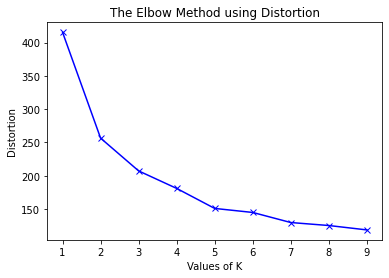

In [376]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [377]:
#X = WRContracts[offense_cluster_cols].fillna(0)
kmeanModel = KMeans(n_clusters=5)#.fit(X)
kmeanModel.fit(X)

KMeans(n_clusters=5)

In [378]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeanModel.labels_)

0.41883414621680887

In [379]:
pd.DataFrame(kmeanModel.labels_).value_counts()

2    21
0    18
3    16
1    14
4     6
dtype: int64

In [321]:
WRContracts[(WRContracts['contract_type'] == 'SFA') & (WRContracts['base_salary'] >= 990000)]['contract_type'].value_counts()

SFA    15
Name: contract_type, dtype: int64

In [334]:
WRContracts[WRContracts['contract_type'] == 'SFA']

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp,KirkComp,contract_id,Total,APY,Guarantee,contract_type,base_salary
0,4363,WR,offense,2021,70.568182,NaN,58.031818,70.495455,NaN,56.600000,60.0,NaN,NaN,60.0,DeSean Jackson,14.0,13.0,0.038,0.000462,510.0,175.0,9.0,3.0,328.0,17.0,19.294118,0.0,257.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2,1.936364,7.600000,31112.0,4500000.0,4500000.0,2750000.0,SFA,2750000.0
3,5606,WR,offense,2021,67.709091,NaN,47.500000,69.922727,NaN,65.863158,NaN,NaN,NaN,NaN,Emmanuel Sanders,12.0,11.0,0.169,-0.017538,511.0,180.0,8.0,2.0,806.0,16.0,50.375000,0.0,667.0,139.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,4,4.795455,10.459091,30841.0,6000000.0,6000000.0,5900000.0,SFA,2800000.0
5,5718,WR,offense,2021,85.968182,NaN,58.050000,84.745455,NaN,63.400000,NaN,NaN,NaN,NaN,Antonio Brown,12.0,11.0,0.209,0.143462,510.0,181.0,8.0,2.0,274.0,7.0,39.142857,0.0,216.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2,13.463636,7.800000,32206.0,3100000.0,3100000.0,3100000.0,SFA,1100000.0
10,7084,WR,offense,2021,62.140909,NaN,55.536364,63.677273,NaN,NaN,NaN,NaN,NaN,NaN,Mohamed Sanu,10.0,9.0,0.041,-0.018538,602.0,215.0,11.0,5.0,243.0,8.0,30.375000,1.0,70.0,170.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,2,10.363636,16.027273,31131.0,1140000.0,1140000.0,25000.0,SFA,1075000.0
16,7789,WR,offense,2021,58.368421,NaN,61.057895,57.684211,NaN,62.800000,NaN,NaN,NaN,NaN,Tavon Austin,9.0,8.0,0.007,-0.063538,508.0,179.0,11.0,4.0,295.0,13.0,22.692308,3.0,147.0,144.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2,14.136124,19.799761,32452.0,1075000.0,1075000.0,0.0,SFA,1075000.0
20,7859,WR,offense,2021,63.477273,NaN,51.250000,65.795455,NaN,53.490909,NaN,NaN,NaN,NaN,Marquise Goodwin,9.0,8.0,0.060,-0.026538,509.0,180.0,10.0,3.0,402.0,14.0,28.714286,6.0,344.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,2,9.027273,14.690909,31228.0,1212500.0,1212500.0,350000.0,SFA,1075000.0
49,10154,WR,offense,2021,58.700000,NaN,56.000000,58.800000,NaN,NaN,NaN,NaN,NaN,NaN,Tyrell Williams,7.0,6.0,-0.001,-0.009538,604.0,205.0,6.0,2.0,39.0,1.0,39.000000,0.0,33.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,0,13.804545,19.468182,30650.0,4000000.0,4000000.0,4000000.0,SFA,2000000.0


In [333]:
WRContracts['contract_type'].value_counts()

UFA          29
Extension    17
SFA           7
ERFA          7
Other         4
Franchise     3
Name: contract_type, dtype: int64

In [320]:
WRContracts['contract_type'].value_counts()

SFA          43
UFA          29
Extension    17
ERFA          7
Other         4
Franchise     3
Name: contract_type, dtype: int64

In [239]:
WRContracts[WRContracts['cluster'] == 4].nsmallest(10, 'MooneyComp')['APY'].quantile(.99) 

19820000.0

In [335]:
WRContracts[WRContracts['cluster'] == 3].nsmallest(10, 'KirkComp')

,player_id,position,unit,season,offense,pass_block,run_block,receiving,pass,run,defense,coverage,pass_rush,run_defense,player,year_in_league,season_count,war,waa,height,weight,total_alignments_played,total_positions_played,total_snap_count,weeks_played,snap_count_per_week_played,HB_total_snaps,WR_total_snaps,SWR_total_snaps,QB_total_snaps,LT_total_snaps,LG_total_snaps,C_total_snaps,RG_total_snaps,RT_total_snaps,FB_total_snaps,TE_total_snaps,LED_total_snaps,RED_total_snaps,LID_total_snaps,RID_total_snaps,NT_total_snaps,LB_total_snaps,SCB_total_snaps,CB_total_snaps,FS_total_snaps,SS_total_snaps,main_position,cluster,MooneyComp,KirkComp,contract_id,Total,APY,Guarantee,contract_type,base_salary
78,11839,WR,offense,2021,77.986364,69.600000,67.113636,76.754545,NaN,65.225000,NaN,NaN,NaN,NaN,Chris Godwin,5.0,4.0,0.347,0.153462,601.0,209.0,14.0,4.0,846.0,14.0,60.428571,2.0,306.0,520.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,5.481818,0.181818,30612.0,15983000.0,15983000.0,15983000.0,Franchise,15983000.0
19,7857,WR,offense,2021,77.113636,NaN,64.977273,77.368182,62.320000,NaN,NaN,NaN,NaN,NaN,Keenan Allen,9.0,8.0,0.312,0.080462,602.0,211.0,14.0,6.0,993.0,16.0,62.062500,5.0,417.0,566.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,4.609091,1.054545,28107.0,80100000.0,20025000.0,32000000.0,Extension,13000000.0
53,10689,WR,offense,2021,71.845455,66.885714,55.350000,72.345455,60.100000,66.116667,NaN,NaN,NaN,NaN,Tyler Boyd,6.0,5.0,0.241,0.001462,602.0,203.0,9.0,3.0,1041.0,20.0,52.050000,3.0,163.0,875.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,0.659091,6.322727,23079.0,43000000.0,10750000.0,9000000.0,Extension,8000000.0
58,10799,WR,offense,2021,84.831818,NaN,64.327273,84.163636,NaN,68.886364,NaN,NaN,NaN,NaN,Tyreek Hill,6.0,5.0,0.476,0.225462,510.0,185.0,16.0,5.0,1070.0,20.0,53.500000,4.0,529.0,524.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WR,3,12.327273,6.663636,24255.0,54000000.0,18000000.0,18340000.0,Extension,990000.0
77,11824,WR,offense,2021,89.804545,56.325000,65.313636,90.168182,72.927273,53.328571,70.2,60.7,NaN,NaN,Cooper Kupp,5.0,4.0,0.885,0.600462,602.0,208.0,14.0,5.0,1324.0,21.0,63.047619,15.0,456.0,843.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,17.300000,11.636364,28271.0,47250000.0,15750000.0,20633000.0,Extension,1500000.0
14,7330,WR,offense,2021,65.940909,NaN,46.445455,66.872727,51.200000,NaN,NaN,NaN,NaN,NaN,Cole Beasley,10.0,9.0,0.126,-0.060538,508.0,174.0,11.0,4.0,756.0,18.0,42.000000,3.0,83.0,669.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SWR,3,6.563636,12.227273,19412.0,29000000.0,7250000.0,10700000.0,UFA,4700000.0


In [247]:
WRContracts[WRContracts['cluster'] == 4].nsmallest(10, 'KirkComp')['APY'].quantile(.25) 

11850000.0

In [336]:
WRContracts['cluster'].value_counts()

2    20
0    18
1    17
4    14
3     6
Name: cluster, dtype: int64

In [257]:
cap21[(cap21['player_id'] == 7857) & (cap21['year'] == 2020)]

,player_id,franchise_id,contract_id,year,base_salary,contract_type,prorated_bonus,roster_bonus,per_game_roster_bonus,workout_bonus,other_bonus,cap_hit,dead_money,cap_savings,guaranteed_base_salary,cash_bonus,cash_pay,cash_to_cap_ratio,initial_cash,old_money,cash_dead,provisional,credits
11765,7857,27,2970,2020,10500000,Extension,1900000.0,0.0,0.0,250000.0,0.0,12650000,NaN,NaN,0.0,0.0,10750000.0,NaN,8750000,0,0.0,NaN,0.0
11770,7857,27,28107,2020,5500000,Extension,4600000.0,0.0,0.0,250000.0,0.0,10350000,NaN,NaN,5500000.0,13500000.0,19250000.0,NaN,19250000,10750000,0.0,NaN,0.0


In [266]:
cap21[(cap21['player_id'] == 7857)]

,player_id,franchise_id,contract_id,year,base_salary,contract_type,prorated_bonus,roster_bonus,per_game_roster_bonus,workout_bonus,other_bonus,cap_hit,dead_money,cap_savings,guaranteed_base_salary,cash_bonus,cash_pay,cash_to_cap_ratio,initial_cash,old_money,cash_dead,provisional,credits
11761,7857,27,2970,2016,1656000,Extension,2053450.0,4000000.0,0.0,15000.0,0.0,7724450,NaN,NaN,5656000.0,9500000.0,15171000.0,NaN,15171000,1671000,0.0,NaN,0.0
11762,7857,27,2970,2017,1000000,Extension,1900000.0,5500000.0,0.0,250000.0,0.0,8650000,NaN,NaN,5500000.0,0.0,6750000.0,NaN,6750000,0,0.0,NaN,0.0
11763,7857,27,2970,2018,7500000,Extension,1900000.0,0.0,0.0,250000.0,0.0,9650000,NaN,NaN,0.0,0.0,7750000.0,NaN,7750000,0,0.0,NaN,0.0
11764,7857,27,2970,2019,10000000,Extension,1900000.0,0.0,0.0,250000.0,0.0,12150000,NaN,NaN,0.0,0.0,10250000.0,NaN,8250000,0,0.0,NaN,0.0
11765,7857,27,2970,2020,10500000,Extension,1900000.0,0.0,0.0,250000.0,0.0,12650000,NaN,NaN,0.0,0.0,10750000.0,NaN,8750000,0,0.0,NaN,0.0
11766,7857,27,8954,2013,405000,Drafted,153450.0,0.0,0.0,0.0,0.0,558450,NaN,NaN,0.0,613800.0,1018800.0,NaN,1018800,0,0.0,NaN,0.0
11767,7857,27,8954,2014,495000,Drafted,153450.0,0.0,0.0,10000.0,0.0,658450,NaN,NaN,0.0,0.0,505000.0,NaN,505000,0,0.0,NaN,0.0
11768,7857,27,8954,2015,585000,Drafted,153450.0,0.0,0.0,15000.0,0.0,753450,NaN,NaN,0.0,0.0,600000.0,NaN,600000,0,0.0,NaN,0.0
11769,7857,27,8954,2016,1656000,Drafted,153450.0,0.0,0.0,15000.0,0.0,1824450,NaN,NaN,0.0,0.0,1671000.0,NaN,675000,0,0.0,NaN,0.0
11770,7857,27,28107,2020,5500000,Extension,4600000.0,0.0,0.0,250000.0,0.0,10350000,NaN,NaN,5500000.0,13500000.0,19250000.0,NaN,19250000,10750000,0.0,NaN,0.0


In [259]:
contracts21[contracts21['pff_id'] == 7857].head()

,Name,Team,pff_id,pff_franchise_id,ID,player_id,team_id,Position,Role,Years,date_signed,year_signed,start_year,Total,APY,Guarantee,GPY,GP,total_guarantees,vested_guarantees,signing_bonus,option_bonus,roster_bonus,pergame_bonus,workout_bonus,incentives,FA,Status,is_featured,is_front,contract_type,ID2
778,Keenan Allen,Chargers,7857,27,28107,2227,15,WR,Offense,4,2020-09-04 00:00:00,2020,2021,80100000,20025000,32000000,0,0.0,50000000,18000000,13500000,0,8500000,0,0,0,NaN,Active,NaN,NaN,Extension,NaN


In [262]:
cap21['contract_type'].value_counts()

SFA           12681
Drafted       10081
UDFA           9604
UFA            7863
Practice       5646
Extension      2920
ERFA            641
Other           624
RFA             519
Franchise       242
Veteran          55
Rookie           42
Transition       18
Name: contract_type, dtype: int64

In [ ]:
# Step 3: offer decision model

# Goal to have model that takes user chosen contract and determines if player will accept, counter, or decline

# inputs: contract chosen from suggestion model, player info, team info
# outputs: decision to accept, counter, or decline

# ideas
# calculate probabilities for each outcome based on contract offer
# probabilities should be fluid (i.e. low offers have higher decline prob, high offers have higher accept prob)
# use probabilities to make decision
# maybe probabilities based on where the contract lies in comparison to other player contracts with similar grade and position
# percentile of X players most closely graded contracts AAV
# future iterations would change weight of probs based on relationships, age, team strengths, agents, etc